## **Shallow Copy**

1=>By changing one, It also affects on other variable,or anything

In [2]:
import copy

a = [1, 2, [3, 4]]
b=copy.copy(a)
b[2].append(5)

print("a:", a)
print("b:", b)

a: [1, 2, [3, 4, 5]]
b: [1, 2, [3, 4, 5]]


In [ ]:
# Deep COPY
a = [1, 2, [3, 4,5,6]]
b=copy.deepcopy(a)
b[2].append(1217)

print("a:", a)
print("b:", b)

a: [1, 2, [3, 4, 5, 6]]
b: [1, 2, [3, 4, 5, 6, 1217]]


**Difference between is and ==?**

==? means value equal
is? means same memory location

**What is StaticMethods and class methods**
1=>Does NOT take self (instance) or cls (class) and Cannot access instance variables or class variables.
2=>classmethods take **cls** orguments, It can change the class states

In [4]:
class MathOps:
    company="ABC Corp"
    @staticmethod
    def add(a, b):
        return a + b
    @classmethod
    def change_company(cls, new_name):
        cls.company = new_name

print(MathOps.add(5, 3))   # 8
print(MathOps.company)     # ABC Corp
MathOps.change_company("XYZ Inc")
print(MathOps.company)     # XYZ Inc

8
ABC Corp
XYZ Inc


In [7]:
## Dict comprehension
my_list=[2,3,4,5,6,7,8,9,10]
squares={x:x**2 for x in range(10)}
lambda_square=list(map(lambda x:x**2,my_list))
print(lambda_square)
# print(squares)

[4, 9, 16, 25, 36, 49, 64, 81, 100]


In [8]:
# Monkey patching example
class Person:
    def greet(self):
        return "Hello!"
def new_greet(self):
    return "Hi there!"
Person.greet = new_greet
p = Person()
print(p.greet())  # Hi there!

Hi there!


In [19]:
from langchain_huggingface import HuggingFaceEndpoint,ChatHuggingFace

In [20]:
from dotenv import load_dotenv
# import os
load_dotenv()

# HUGGINGFACE_ACCESS_TOKEN=os.getenv("HUGGINGFACE_ACCESS_TOKEN")
# print(HUGGINGFACE_ACCESS_TOKEN)

True

In [21]:
model = HuggingFaceEndpoint(
    repo_id="TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    task="text-generation"
    )

In [ ]:
chat_model = ChatHuggingFace(llm=model)

In [ ]:
chat_model.invoke("Hello, how are you?")

In [ ]:
from langchain_huggingface import HuggingFaceEndpoint

model = HuggingFaceEndpoint(
    repo_id="TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    task="text-generation",
    max_new_tokens=256,
)

response = model.invoke("Hello, how are you?")
print(response)

# **How Planner works in LangGraph**

In [1]:
print("End of the script.")

End of the script.


In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

/tmp/ipykernel_97886/2518516040.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tools = [TavilySearchResults(max_results=3)]


In [10]:
from langchain_openai import ChatOpenAI

from langchain.agents import create_agent

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4-turbo-preview",api_key=OPENAI_API_KEY)
prompt = "You are a helpful assistant."
agent_executor = create_agent(llm, tools, system_prompt=prompt)

In [13]:
response=agent_executor.invoke({"messages": [("user", "Who is the president of the United States?")]})

In [16]:
response["messages"][-1].content
# print(response.content)

'The President of the United States is Joe Biden. He assumed office on January 20, 2021.'

In [ ]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecuteState(TypedDict):
    input: str
    plan: List[str]
    response: str

In [33]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import Image, display,Markdown

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective or user input query,You have to behave like planner engineer that breaks the bigger problem into smaller one and come up with a simple step by step plan.For any problem scenario, you need to make step by step and bullet points plan to solve that problems.The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)


In [52]:
def planner_node(state: PlanExecuteState):
    """Generates a plan from user input."""
    user_input = state["input"]
    
    planner = planner_prompt | ChatOpenAI(
        model="gpt-4o", temperature=0,api_key=OPENAI_API_KEY
    ).with_structured_output(Plan)
    
    planner_response=planner.invoke(
        {
            "messages": [
                ("user", user_input)
            ]
        }
    )
    display(Markdown("\n\n".join(f"{i+1}. {s}" for i,s in enumerate(planner_response.steps))))
    
    return {"plan": planner_response.steps}

In [53]:
executor_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given list of planner{plan},You have to behave like executor the plan like developer those converts the requirements into code.The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{plan}"),
    ]
)

In [63]:
def generate_response_from_plan(state: PlanExecuteState):
    plan = state["plan"]
    executor_agent=executor_prompt | ChatOpenAI(
        model="gpt-4o", temperature=0,api_key=OPENAI_API_KEY
    )
    final_response = executor_agent.invoke({"plan": plan})
    print(final_response)
    return {"response": final_response}

In [64]:
from langgraph.graph import StateGraph, START,END

workflow = StateGraph(PlanExecuteState)

# Add the plan node
workflow.add_node("planner", planner_node)
# Add the execution step
workflow.add_node("agent", generate_response_from_plan)


workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")
workflow.add_edge("agent", END)
app = workflow.compile()

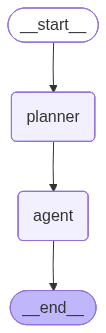

In [65]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [79]:
response=app.invoke({"input":"How Nginx works as a load balancer?"})

1. Understand the basic concept of load balancing: Load balancing is the process of distributing network or application traffic across multiple servers to ensure no single server becomes overwhelmed, thus improving responsiveness and availability.

2. Learn about Nginx: Nginx is a high-performance web server that can also be used as a reverse proxy, load balancer, and HTTP cache.

3. Install Nginx: Ensure Nginx is installed on your server. This can typically be done using package managers like apt for Ubuntu or yum for CentOS.

4. Configure Nginx for load balancing: Open the Nginx configuration file, usually located at /etc/nginx/nginx.conf or /etc/nginx/conf.d/your-config-file.conf.

5. Define the upstream servers: In the configuration file, define the upstream block where you list the backend servers that Nginx will distribute traffic to. For example: 
 upstream backend {
    server backend1.example.com;
    server backend2.example.com;
 }

6. Set up the server block: Configure the server block to use the upstream group. This is where you define the load balancing method (e.g., round-robin, least connections, IP hash). For example: 
 server {
    listen 80;
    location / {
        proxy_pass http://backend;
    }
 }

7. Choose a load balancing method: Nginx supports several load balancing methods such as round-robin (default), least connections, and IP hash. Choose the one that best fits your needs and configure it in the upstream block.

8. Test the configuration: Before applying the changes, test the Nginx configuration for syntax errors using the command: nginx -t.

9. Reload Nginx: If the configuration test is successful, reload Nginx to apply the changes using the command: nginx -s reload.

10. Monitor and optimize: Continuously monitor the performance of your load balancer and backend servers. Adjust configurations as needed to optimize performance and handle traffic efficiently.

content="To complete the final step, you need to set up a monitoring and optimization strategy for your Nginx load balancer and backend servers. Here's a detailed approach:\n\n1. **Monitoring Tools**: \n   - Use tools like **Prometheus** and **Grafana** for real-time monitoring and visualization of server metrics.\n   - Implement **Nginx Amplify** for monitoring Nginx performance metrics.\n   - Consider using **ELK Stack (Elasticsearch, Logstash, Kibana)** for log management and analysis.\n\n2. **Metrics to Monitor**:\n   - **Server Load**: Monitor CPU, memory, and disk usage on both the load balancer and backend servers.\n   - **Network Traffic**: Keep an eye on incoming and outgoing traffic to identify any bottlenecks.\n   - **Response Time**: Measure the time taken to serve requests to ensure it remains within acceptable limits.\n   - **Error Rates**: Track HTTP error codes to identify issues with server responses.\n\n3. **Optimization Strategies**:\n   - **Configuration Tuning**: A

In [81]:
response

{'input': 'How Nginx works as a load balancer?',
 'plan': ['Understand the basic concept of load balancing: Load balancing is the process of distributing network or application traffic across multiple servers to ensure no single server becomes overwhelmed, thus improving responsiveness and availability.',
  'Learn about Nginx: Nginx is a high-performance web server that can also be used as a reverse proxy, load balancer, and HTTP cache.',
  'Install Nginx: Ensure Nginx is installed on your server. This can typically be done using package managers like apt for Ubuntu or yum for CentOS.',
  'Configure Nginx for load balancing: Open the Nginx configuration file, usually located at /etc/nginx/nginx.conf or /etc/nginx/conf.d/your-config-file.conf.',
  'Define the upstream servers: In the configuration file, define the upstream block where you list the backend servers that Nginx will distribute traffic to. For example: \n upstream backend {\n    server backend1.example.com;\n    server backe

In [82]:
print("User Input:",response['input'])

User Input: How Nginx works as a load balancer?


In [83]:
print("Plan and Execution Steps:", response['plan'])

Plan and Execution Steps: ['Understand the basic concept of load balancing: Load balancing is the process of distributing network or application traffic across multiple servers to ensure no single server becomes overwhelmed, thus improving responsiveness and availability.', 'Learn about Nginx: Nginx is a high-performance web server that can also be used as a reverse proxy, load balancer, and HTTP cache.', 'Install Nginx: Ensure Nginx is installed on your server. This can typically be done using package managers like apt for Ubuntu or yum for CentOS.', 'Configure Nginx for load balancing: Open the Nginx configuration file, usually located at /etc/nginx/nginx.conf or /etc/nginx/conf.d/your-config-file.conf.', 'Define the upstream servers: In the configuration file, define the upstream block where you list the backend servers that Nginx will distribute traffic to. For example: \n upstream backend {\n    server backend1.example.com;\n    server backend2.example.com;\n }', 'Set up the serve

In [84]:
print("Response:")
display(Markdown(response["response"].content))


Response:


To complete the final step, you need to set up a monitoring and optimization strategy for your Nginx load balancer and backend servers. Here's a detailed approach:

1. **Monitoring Tools**: 
   - Use tools like **Prometheus** and **Grafana** for real-time monitoring and visualization of server metrics.
   - Implement **Nginx Amplify** for monitoring Nginx performance metrics.
   - Consider using **ELK Stack (Elasticsearch, Logstash, Kibana)** for log management and analysis.

2. **Metrics to Monitor**:
   - **Server Load**: Monitor CPU, memory, and disk usage on both the load balancer and backend servers.
   - **Network Traffic**: Keep an eye on incoming and outgoing traffic to identify any bottlenecks.
   - **Response Time**: Measure the time taken to serve requests to ensure it remains within acceptable limits.
   - **Error Rates**: Track HTTP error codes to identify issues with server responses.

3. **Optimization Strategies**:
   - **Configuration Tuning**: Adjust Nginx configuration parameters such as worker processes, worker connections, and buffer sizes based on traffic patterns.
   - **Caching**: Implement caching strategies to reduce load on backend servers and improve response times.
   - **Load Balancing Method**: Re-evaluate the chosen load balancing method (round-robin, least connections, IP hash) and adjust if necessary based on traffic patterns.
   - **Scaling**: Consider horizontal scaling by adding more backend servers if traffic consistently exceeds current capacity.

4. **Regular Audits**:
   - Conduct regular audits of your configuration and performance metrics to ensure optimal operation.
   - Stay updated with the latest Nginx releases and apply updates to benefit from performance improvements and security patches.

By implementing these monitoring and optimization strategies, you can ensure that your Nginx load balancer and backend servers operate efficiently, providing high availability and responsiveness to your users.

In [85]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.2",
    temperature=0
)

response = llm.invoke("Explain Docker in simple terms.")
print(response)


content='Docker is a way to package, ship, and run software applications in containers.\n\nThink of it like shipping a box:\n\n* You have an application (like a website or a game) that you want to deploy on different computers.\n* Instead of copying the entire operating system onto each computer, you can put just the application inside a special container called a "docker container".\n* The container includes everything your application needs to run, like libraries and dependencies.\n* When you send the container to another computer, it\'s like sending a box with all the necessary stuff for your application.\n\nHere are some key benefits of Docker:\n\n1. **Lightweight**: Containers are much smaller than full operating systems, so they take up less space on your computer or server.\n2. **Portable**: You can move containers from one computer to another without worrying about compatibility issues.\n3. **Isolated**: Each container runs in its own isolated environment, so if something goes 

In [87]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an expert DevOps engineer."),
    ("user", "{question}")
])

llm = ChatOllama(model="llama3.2")

chain = prompt | llm

result = chain.invoke({"question": "What is Docker?"})
print(result.content)

Docker is a containerization platform that allows developers to package, ship, and run applications in containers. Containers are lightweight and portable, providing a consistent and reliable way to deploy applications across different environments.

With Docker, you can:

1. **Package your application**: You create a Docker image, which includes the application code, dependencies, and libraries needed to run it.
2. **Ship your container**: The Docker image is packaged into a container, which can be easily shared with others or deployed to production.
3. **Run your container**: The container is executed on a host machine or in a cloud environment, providing a consistent runtime environment for the application.

Docker offers several benefits, including:

1. **Lightweight and portable**: Containers are much smaller than virtual machines, making them easier to deploy and manage.
2. **Isolated environments**: Containers provide a secure and isolated environment for applications, reducing 

In [88]:
for chunk in llm.stream("Give me Docker basics."):
    print(chunk.content, end="")

Here's a comprehensive overview of Docker basics:

**What is Docker?**

Docker is a containerization platform that allows developers to package, ship, and run applications in containers. Containers are lightweight and standalone, providing a consistent and reliable way to deploy applications.

**Key Concepts:**

1. **Images**: A template for creating containers. Images contain the code, libraries, and settings needed to run an application.
2. **Containers**: Running instances of images. Containers provide a isolated environment for running applications.
3. **Docker Hub**: A registry of available Docker images that can be easily pulled and pushed.

**Basic Docker Commands:**

1. `docker run`: Runs a container from an image.
Example: `docker run -it ubuntu /bin/bash`
2. `docker ps`: Lists all running containers.
3. `docker stop`: Stops a container.
4. `docker rm`: Removes a stopped container.
5. `docker images`: Lists all available Docker images on the system.
6. `docker pull`: Pulls an 

In [91]:
markdown_output = ""

for chunk in llm.stream("Give me Docker basics in Markdown."):
    markdown_output += chunk.content

display(Markdown(markdown_output))

Docker Basics
================

### What is Docker?

Docker is a containerization platform that allows developers to package, ship, and run applications in containers.

### Key Concepts

#### Containers

*   A lightweight and portable way to deploy applications.
*   A single process can be multiple containers.
*   Can communicate with each other through API calls.

#### Images

*   The foundation of a container.
*   A read-only template for an application.
*   Includes the application code, libraries, and runtime environment.
*   Can be shared among different environments.

#### Docker Hub

*   A central registry for Docker images.
*   Allows users to push, pull, and manage images.
*   Provides a convenient way to share images with others.

### Installing Docker

To install Docker on your system:

1.  Go to the official [Docker website](https://www.docker.com/get-started) and download the installation package for your operating system.
2.  Follow the instructions provided in the installation guide to complete the installation process.

### Basic Docker Commands

#### Running a Container

```bash
docker run -it --rm <image-name>
```

*   `-it`: Run the container interactively.
*   `--rm`: Delete the container after it is closed.
*   `<image-name>`: The name or ID of the image to use.

#### Creating a New Image

```bash
docker build -t <image-name> .
```

*   `-t`: Specify the name and tag for the new image.
*   `<image-name>`: The desired name for the new image.
*   `.`: The directory containing the application code.

#### Listing Images

```bash
docker images
```

Displays a list of all available images on your system.

### Docker Network

Docker networks allow containers to communicate with each other.

*   Create a network:

    ```bash
docker network create <network-name>
```

*   Use the created network for a container:
    ```bash
docker run -it --net <network-name> <image-name>
```
*   Connect two containers using the network:

    ```bash
docker exec -it container1 docker connect container2 -n <network-name>
```

### Docker Compose

Docker Compose is used to define and run multi-container Docker applications.

*   Define a `docker-compose.yml` file:
    ```yml
version: '3'
services:
  web:
    build: .
    ports:
      - "8080:8080"
    depends_on:
      - db
  db:
    image: postgres
```

*   Run the application:

    ```
docker-compose up
```
*   Stop the application:

    ```bash
docker-compose down
```

None


In [92]:
import subprocess
from langchain_ollama import ChatOllama
from IPython.display import Markdown, display

def get_ollama_llm(model_name="llama3.2"):
    """
    Checks:
    1. ollama installation
    2. ollama model availability
    Returns ChatOllama instance or raises helpful errors.
    """

    # --- Check if ollama installed ---
    try:
        result = subprocess.run(
            ["ollama", "--version"],
            capture_output=True,
            text=True
        )
        
        if result.returncode != 0:
            raise EnvironmentError("Ollama is installed? Command failed.")

        print("✅ Ollama installed:", result.stdout.strip())

    except FileNotFoundError:
        raise EnvironmentError(
            "❌ Ollama is not installed on your system.\n"
            "Install it: https://ollama.com"
        )

    # --- Check if model exists ---
    try:
        model_list = subprocess.run(
            ["ollama", "list"],
            capture_output=True,
            text=True
        ).stdout
        
        if model_name not in model_list:
            raise ValueError(
                f"❌ Model '{model_name}' not found.\n"
                f"Install it using:  ollama pull {model_name}"
            )

        print(f"✅ Model '{model_name}' found.")

    except Exception as e:
        raise RuntimeError(f"Error checking model: {str(e)}")

    # --- Return LangChain LLM instance ---
    print("🚀 Loading model with LangChain...")
    return ChatOllama(model=model_name)


In [93]:
get_ollama_llm()

✅ Ollama installed: ollama version is 0.13.2
✅ Model 'llama3.2' found.
🚀 Loading model with LangChain...


ChatOllama(model='llama3.2')

In [94]:
from pydantic import BaseModel, Field

class DockerBasicsResponse(BaseModel):
    user_query: str = Field(..., description="The user's input question about Docker.")
    basics: str = Field(..., description="The basics of Docker explained in simple terms.")
    intermediate_steps: str = Field(..., description="Any intermediate steps or explanations.")
    advance_concepts: str = Field(..., description="Advanced concepts related to Docker.")

In [95]:
llm = get_ollama_llm()

✅ Ollama installed: ollama version is 0.13.2
✅ Model 'llama3.2' found.
🚀 Loading model with LangChain...


In [96]:
response=llm.with_structured_output(DockerBasicsResponse).invoke("Explain Docker for Learning and DevOPs Engineer?")

In [98]:
print(response.user_query)

explain docker for learning and devop engineer


In [100]:
print(response.basics)

Docker is an open-source platform for building, shipping, and running containerized applications. It's a lightweight and portable way to deploy software, making it easier to manage and scale applications.


In [101]:
response.intermediate_steps

"Here are some key concepts and skills you'll need to know as a learning and DevOps engineer: \n\n1. Containerization: Understanding how Docker containers work and how they can be used to package and deploy applications.\n2. Images and Volumes: Learning about Docker images, volumes, and how they're used to persist data in containers.\n3. Networking and Ports: Understanding how Docker handles networking and port mappings.\n4. Docker Compose: Using Docker Compose to define and run multi-container applications.\n5. Orchestration: Understanding how Docker Swarm or Kubernetes can be used to orchestrate multiple containers across a cluster."

In [103]:
response.advance_concepts

"Some advanced concepts in Docker include:\n\n1. Dockerfile: Creating custom Docker images using the Dockerfile syntax.\n2. Docker Volumes: Using Docker volumes to persist data between container restarts.\n3. Docker Network Mode: Understanding different network modes (bridge, host, etc.) and how they're used.\n4. Docker Secret Management: Managing sensitive data using Docker secrets.\n5. CI/CD Pipelines: Integrating Docker with continuous integration and delivery pipelines."